<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
<h1> This notebook walks us through how to compute a tuning curve using the Allen Brain Observatory data </h1>
    
A tuning curve summarizes a neuron's response to stimulus categories. Here we will look at the responses of a neuron to the 'Drifting Gratings' stimulus.

The Drifting Gratings stimulus consists of a sinusoidal grating that moves in 8 directions and at 5 temporal frequencies. Each stimulus condition (direction + temporal frequency combination) is repeated 15 times in random order. In addition, there are blanksweeps (when the grating is replaced with mean luminance gray) interleaved among the trials.

We will compute the mean response of a neuron to each of these stimulus conditions.
</div>

<a href="https://colab.research.google.com/github/allenswdb/TReND-CaMinA/notebooks/Zambia25/07-to-10-Mon-toThu-AllenTutorial/Session_2_Tuning_Curves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# run only once per runtime/session, and only if running in colab
# the runtime will need to restart after
%%capture
!apt install s3fs
!pip install allensdk
!mkdir -p /data/allen-brain-observatory/
!s3fs allen-brain-observatory /data/allen-brain-observatory/ -o public_bucket=1

import time
print("Runtime is now restarting...")
print("You can ignore the error message [Your session crashed for an unknown reason.]")
time.sleep(5)
exit()

### Standard imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Allen Brain Observatory set up

This instantiates the tools in the Allen SDK that allow us to access the Brain Observatory data.

In [2]:
# standard data access code
import os
import sys
import platform
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

# Set file location based on platform.
platstring = platform.platform()
if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS
    data_root = "/Volumes/TReND2025/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring) or ('google.colab' in sys.modules):
    # then on Code Ocean or Colab
    data_root = "/data/"
elif 'Linux' in platstring:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/TReND2025/"

# if running locally without external drive, set a local path to download data
# data_root = '/path/to/data'

manifest_file = os.path.join(data_root,'allen-brain-observatory/visual-coding-2p/manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_file)

We'll look at one cell to start

In [3]:
cell_id = 541513979

<p>In order to compute the tuning curve of the neuron, we need to access

<li>the activity of the neuron.  We will use the DF/F trace
<li>stimulus information for the drifting grating stimulus

<p>We have written the function below that uses the AllenSDK to get these pieces of data. It does so by first identifying which experiment session contains the specified cell id and stimulus. It then accesses the NWB file for that session and reads the DF/F trace for the specified cell and the stimulus table for the specified stimulus.

In [4]:
# identify the session for a given cell id and stimulus
# here we use the cell id of the cell we chose above and look for
# sessions with the 'drifting_gratings' stimulus
exps = boc.get_ophys_experiments(cell_specimen_ids=[cell_id], stimuli=['drifting_gratings'])

In [5]:
exps[0]

{'id': 540684467,
 'imaging_depth': 175,
 'targeted_structure': 'VISp',
 'cre_line': 'Emx1-IRES-Cre',
 'reporter_line': 'Ai93(TITL-GCaMP6f)',
 'acquisition_age_days': 120,
 'experiment_container_id': 536323956,
 'session_type': 'three_session_A',
 'donor_name': '252174',
 'specimen_name': 'Emx1-IRES-Cre;Camk2a-tTA;Ai93(MG)-252174',
 'fail_eye_tracking': False}

In [6]:
#get the session_id for that session
session_id = exps[0]['id']

#access the data for that session
data_set = boc.get_ophys_experiment_data(session_id)

In [7]:
#get the DFF trace for the cell
timestamps, dff = data_set.get_dff_traces(cell_specimen_ids=[cell_id])
dff_trace = dff[0,:]

#get the stimulus table for the stimulus
stim_table = data_set.get_stimulus_table('drifting_gratings')

It is always good to look at the data objects you're working with to make sure you understand what they are. What is the shape of the dff_trace array?

In [8]:
dff_trace.shape

(115741,)

Plot the DF/F trace of our neuron to see what it looks like

Text(0, 0.5, 'DFF')

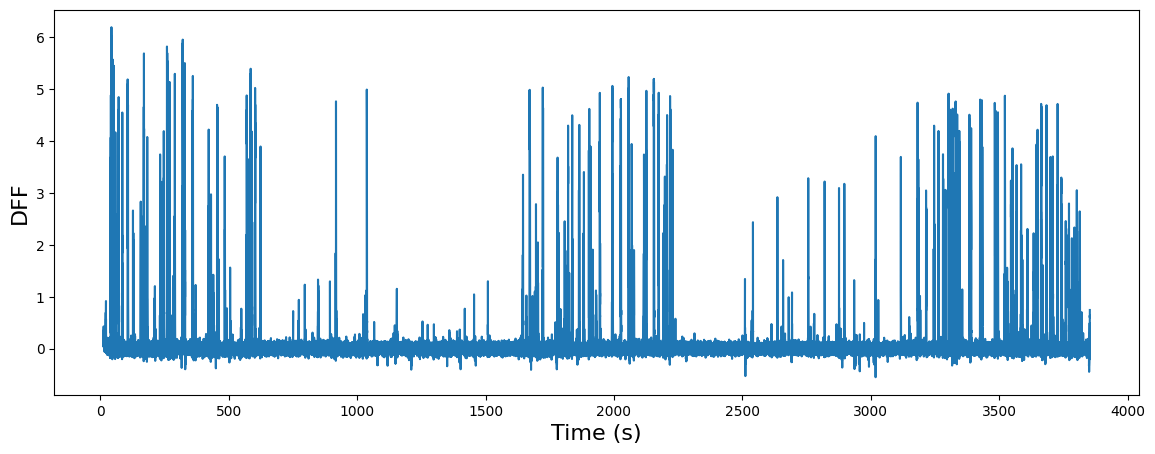

In [9]:
plt.figure(figsize=(14,5))
plt.plot(timestamps, dff_trace)
plt.xlabel("Time (s)", fontsize=16)
plt.ylabel("DFF", fontsize=16)

Now look at our stimulus table to see what information we have. This is a Pandas DataFrame, which is a flexible and powerful tool for analyzing large datasets.For now we just want to see the first few lines to understand what the structure is, so use the function `head` to see the top of this DataFrame. This shows us the first five rows of the DataFrame.

In [10]:
stim_table.head(n=10)

,temporal_frequency,orientation,blank_sweep,start,end
0,1.0,45.0,0.0,736,796
1,15.0,90.0,0.0,826,886
2,1.0,270.0,0.0,917,977
3,NaN,NaN,1.0,1007,1067
4,4.0,90.0,0.0,1098,1158
5,1.0,270.0,0.0,1188,1248
6,2.0,135.0,0.0,1279,1339
7,4.0,270.0,0.0,1370,1429
8,4.0,45.0,0.0,1460,1520
9,4.0,0.0,0.0,1551,1610


The stimulus table has 5 columns.  `start` and `end` indicate the <b>frame number</b> when a given trial starts and ends, respectively. The other columns indicate what the grating condition is for that trial, including the `temporal frequency` of the grating (in Hz), the direction (called `orientation`) of the grating (in degrees), and whether the grating is a `blank sweep` (eg. a gray screen). Each row is a single trial. How many trials are there in total?

In [11]:
len(stim_table)

628

In [12]:
stim_table.start[0]

736

<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
**Quick pandas tutorial for our purposes today!**

To access data from a DataFrame we must specify the column we are using and specify the row using the index. To specify a column we can use two methods:

```stim_table['start']```

```stim_table.start```

Then to specify the row we want we must use the index of that row:

```stim_table['start'][0]```

```stim_table.start[0]```

We can also subselect portions of the DataFrame using the values in the DataFrame. For example, to select only the rows of the table where the orientation is 90 degrees we can use:

```stim_table[stim_table.orientation==90]```

Try this yourself. Note the index. The rows of this subselected DataFrame maintain the indices of the original DataFrame. Now in order to get a specific row, you either need to know it's original index, or use iloc. For example, this will return the first row of the subselected DataFrame regardless of the original index of that row:

```stim_table[stim_table.orientation==90].iloc[0]```
</div>

In [13]:
stim_table[stim_table.orientation==90]

,temporal_frequency,orientation,blank_sweep,start,end
1,15.0,90.0,0.0,826,886
4,4.0,90.0,0.0,1098,1158
11,1.0,90.0,0.0,1732,1791
23,4.0,90.0,0.0,2818,2878
44,2.0,90.0,0.0,4719,4779
...,...,...,...,...,...
588,4.0,90.0,0.0,111895,111955
598,15.0,90.0,0.0,112800,112860
603,15.0,90.0,0.0,113253,113312
613,15.0,90.0,0.0,114158,114218


Task: How many unique temporal frequencies and orientations are there in this stimulus? Print the unique values for each of these parameters.

In [14]:
stim_table.temporal_frequency.unique()

array([ 1., 15., nan,  4.,  2.,  8.], dtype=float32)

In [15]:
stim_table.orientation.unique()

array([ 45.,  90., 270.,  nan, 135.,   0., 225., 315., 180.],
      dtype=float32)

To look at the cell's response to a given grating presentation, let's plot the DF/F of the cell during the presentation of that grating.  We want to pad the plot with ~ 1 second of the DF/F trace preceding the grating presentation.  1 second = 30 frames.  We'll plot the response to the first grating presentation.

Text(0.5, 0, 'Frames')

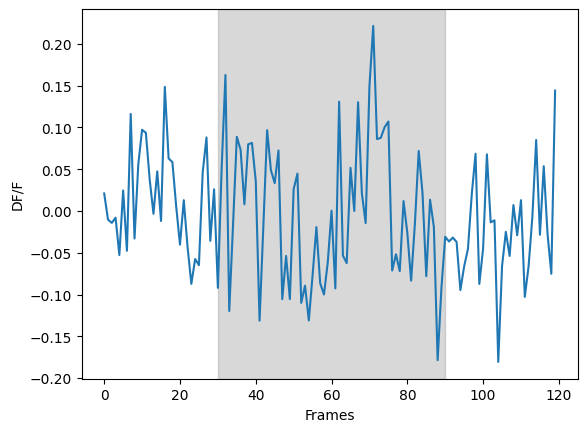

In [16]:
plt.plot(dff_trace[stim_table.start[0]-30:stim_table.end[0]+30])
plt.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
plt.ylabel("DF/F")
plt.xlabel("Frames")

We want to quantify this response. There are different methods of quantifying this that you can explore:
* mean DF/F during the grating presentation
* sum of the DF/F during the grating presentation (are these different?)
* maximum DF/F during grating

Do you have other ideas for how to quantify this response?

For now let's use the mean DF/F during the presentation of the grating.

In [17]:
dff_trace[stim_table.start[0]:stim_table.end[0]].mean()

-0.0020014683

**Exercise 1:** Repeat this for the next grating stimulus: plot the next trial and calculate the mean DF/F.

Text(0.5, 0, 'Frames')

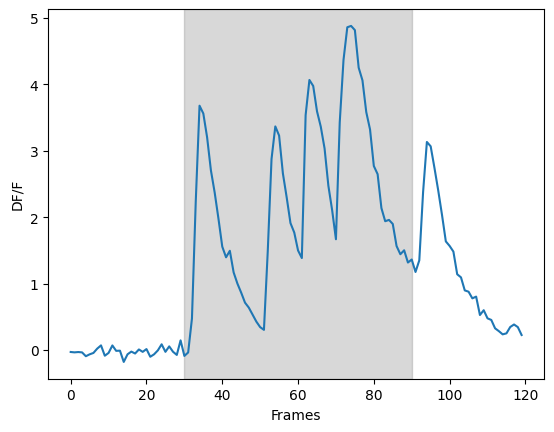

In [18]:
plt.plot(dff_trace[stim_table.start[1]-30:stim_table.end[1]+30])
plt.axvspan(30,90, color='gray', alpha=0.3) #this shades the period when the stimulus is being presented
plt.ylabel("DF/F")
plt.xlabel("Frames")

In [19]:
dff_trace[stim_table.start[1]:stim_table.end[1]].mean()

2.292613

Already we can see that some stimulus conditions elicit larger responses than others.  This is what we want to quantify and summarize in a <b>tuning curve</b>.

<p>To do this, let's calculate the mean DF/F for each grating presentation in this stimulus. To start, let's create a numpy array to hold our calculated responses for all of the trials. We'll have three columns, one for the stimulus orientation, one for the stimulus temporal frequency, and the last for the cell's response. Then we need to iterate over all stimulus trials, populate the orientation and TF and then calculate the mean response.
    

In [20]:
cell_response= np.zeros((len(stim_table),3))
for i in range(len(stim_table)):
    cell_response[i,0] = stim_table.orientation[i] #orientation
    cell_response[i,1] = stim_table.temporal_frequency[i] #temporal frequency
    cell_response[i,2] = dff_trace[stim_table.start[i]:stim_table.end[i]].mean()#mean response

In [21]:
cell_response

array([[ 4.50000000e+01,  1.00000000e+00, -2.00146833e-03],
       [ 9.00000000e+01,  1.50000000e+01,  2.29261303e+00],
       [ 2.70000000e+02,  1.00000000e+00,  4.73994493e+00],
       ...,
       [ 4.50000000e+01,  1.50000000e+01,  6.65871147e-03],
       [ 3.15000000e+02,  1.00000000e+00, -3.49607458e-03],
       [ 4.50000000e+01,  1.00000000e+00,  2.98597999e-02]])

If we only care about one stimulus parameter, we can quickly compare the response to that parameter, say the direction. Here we will plot each grating response as a function of the grating orientation.

Text(0, 0.5, 'Mean DF/F')

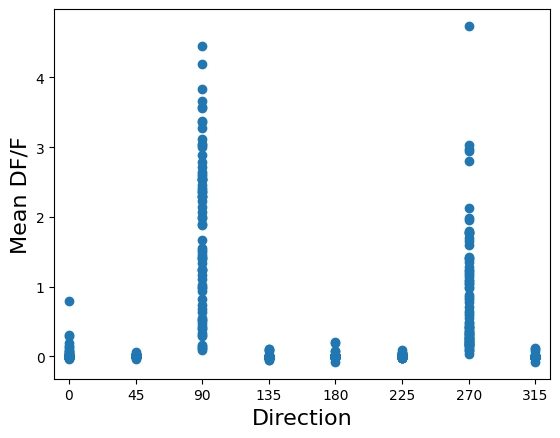

In [22]:
plt.plot(cell_response[:,0], cell_response[:,2], 'o')

plt.xticks(range(0,360,45))
plt.xlim(-10,325)
plt.xlabel("Direction", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
What do we see?
</div>

**Exercise 2:** Repeat this for the temporal frequency parameter

Text(0, 0.5, 'Mean DF/F')

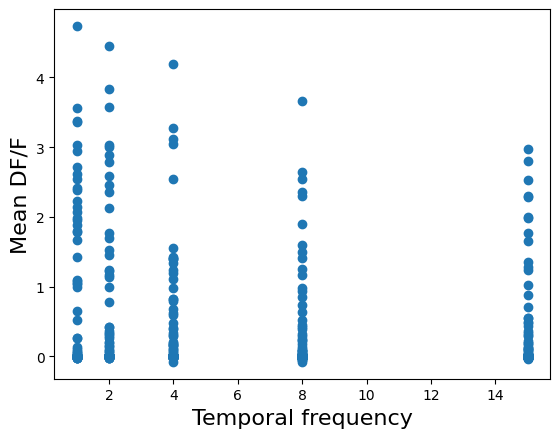

In [23]:
plt.plot(cell_response[:,1], cell_response[:,2], 'o')

# plt.xticks(range(0,360,45))
# plt.xlim(-10,325)
plt.xlabel("Temporal frequency", fontsize=16)
plt.ylabel("Mean DF/F", fontsize=16)

We want to quantify this more explicitly.  So let's average all of the responses to each orientation together. This is the mean DF/F response to an orientation, for all temporal frequencies, for all trials.  For example, for orientation=270:

In [24]:
#Find the trials where the orientation is 270
trials = cell_response[:,0]==270
#Average the mean DF/F of just those trials together
cell_response[trials,2].mean()

0.9247032543023427

Let's compute and plot the mean response as a function of orientation (averaged across all temporal frequencies).
    
<p> To start, we need to know what all the possible orientation values are. We need to identify the <b>unique</b> values that are not NaNs (e.g. values that are <b>finite</b>)

In [25]:
all_ori = np.unique(cell_response[:,0])
orivals = all_ori[np.isfinite(all_ori)]
print(orivals)

[  0.  45.  90. 135. 180. 225. 270. 315.]


Now let's make an array with the average response of all trials for each of these orientations.
    
<p> We can use <b>enumerate</b> to iterate over the orientations in our list. Let me show you the syntax for enumerate. It iterates across the object and returns both the iterator (i.e. the index) and the value for each iteration.

<p> Always remember that if you don't understand a python function you can use ? to get the docstring to help you understand it.

In [26]:
? enumerate

Init signature:  enumerate(iterable, start=0)
Docstring:     
Return an enumerate object.

  iterable
    an object supporting iteration

The enumerate object yields pairs containing a count (from start, which
defaults to zero) and a value yielded by the iterable argument.

enumerate is useful for obtaining an indexed list:
    (0, seq[0]), (1, seq[1]), (2, seq[2]), ...
Type:           type
Subclasses:     

In [27]:
for i, ori in enumerate(orivals):
    print(i, ori)

0 0.0
1 45.0
2 90.0
3 135.0
4 180.0
5 225.0
6 270.0
7 315.0


We can now enumerate across orivals to get the trials for each orientation and put the average response for those trials into an array.

In [28]:
tuning = np.empty((8))
for i, ori in enumerate(orivals):
    trials = cell_response[:,0]==ori
    tuning[i] = cell_response[trials,2].mean()

Let's plot this tuning curve of mean response vs orientation.

Text(0, 0.5, 'Mean DF/F')

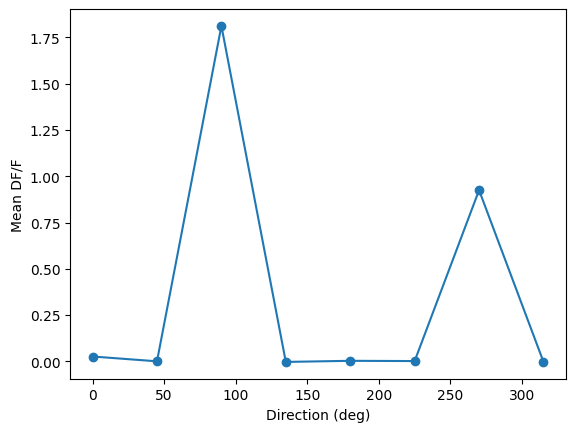

In [29]:
plt.plot(orivals, tuning, 'o-')
plt.xlabel("Direction (deg)")
plt.ylabel("Mean DF/F")

**Exercise 3:** Compute and plot the mean response as a function of temporal frequency (averaged across all orientations).

In [30]:
all_tf = np.unique(cell_response[:,1])
tfvals = all_tf[np.isfinite(all_tf)]
print(tfvals)

[ 1.  2.  4.  8. 15.]


In [31]:
tuning_tf = np.empty((5))
for i, tf in enumerate(tfvals):
    trials = cell_response[:,1]==tf
    tuning_tf[i] = cell_response[trials,2].mean()

Text(0, 0.5, 'Mean DF/F')

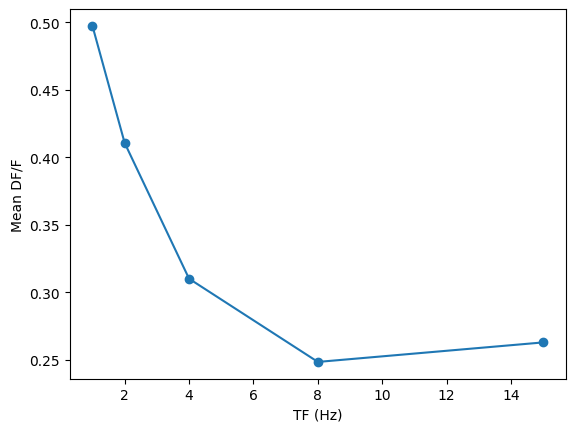

In [32]:
plt.plot(tfvals, tuning_tf, 'o-')
plt.xlabel("TF (Hz)")
plt.ylabel("Mean DF/F")

<div style="background: #F0FAFF; border-radius: 3px; padding: 10px;">
Compare these curves with the plots we made above of all the trials. What do we see now?
</div>

**Exercise 4:** Add errorbars to the above tuning curves. They can be standard deviation or standard error or the mean. Make a new array for the tuning values with two columns - one for the mean response and one for the error you decide to use
    
<p>(Hint: for plotting, <b>plt.errorbar</b> will be useful).

In [ ]:
tuning = np.empty((8,2))
for i, ori in enumerate(orivals):
    trials = cell_response[:,0]==ori
    tuning[i,0] = cell_response[trials,2].mean()
    tuning[i,1] = cell_response[trials,2].std()

In [34]:
? plt.errorbar

Signature:
 plt.errorbar(
    x: 'float | ArrayLike',
    y: 'float | ArrayLike',
    yerr: 'float | ArrayLike | None' = None,
    xerr: 'float | ArrayLike | None' = None,
    fmt: 'str' = '',
    ecolor: 'ColorType | None' = None,
    elinewidth: 'float | None' = None,
    capsize: 'float | None' = None,
    barsabove: 'bool' = False,
    lolims: 'bool | ArrayLike' = False,
    uplims: 'bool | ArrayLike' = False,
    xlolims: 'bool | ArrayLike' = False,
    xuplims: 'bool | ArrayLike' = False,
    errorevery: 'int | tuple[int, int]' = 1,
    capthick: 'float | None' = None,
    *,
    data=None,
    **kwargs,
) -> 'ErrorbarContainer'
Docstring:
Plot y versus x as lines and/or markers with attached errorbars.

*x*, *y* define the data locations, *xerr*, *yerr* define the errorbar
sizes. By default, this draws the data markers/lines as well as the
errorbars. Use fmt='none' to draw errorbars without any data markers.

.. versionadded:: 3.7
   Caps and error lines are drawn in polar coord

Text(0, 0.5, 'Mean DF/F')

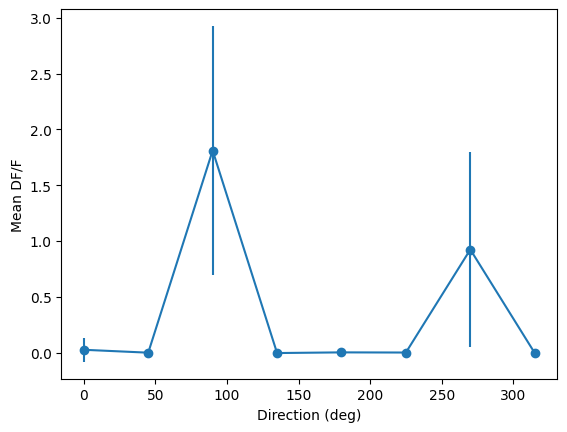

In [ ]:
plt.errorbar(orivals, tuning[:,0], yerr=tuning[:,1], marker='o')
plt.xlabel("Direction (deg)")
plt.ylabel("Mean DF/F")

**Exercise 5:** Add a black line showing the mean response to the blank sweep.
<br>(Hint 1: orientation and temporal frequency are NaN for the blank sweep condition.  Hint 2: <b>plt.axhline</b> is a useful function for adding a horizontal line).

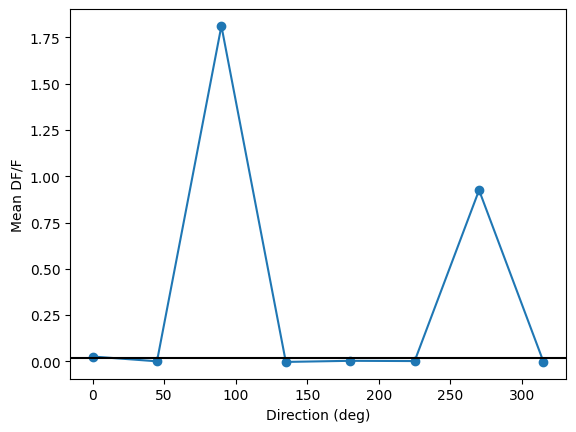

In [48]:
blank_sweep_mask = np.isnan(cell_response[:,0])
blank_response_mean = cell_response[blank_sweep_mask,2].mean()

plt.plot(orivals, tuning[:,0], 'o-')
plt.xlabel("Direction (deg)")
plt.ylabel("Mean DF/F")
plt.axhline(blank_response_mean, color='k')

Why is it important to add these two features?

**Exercise 6:** Add the errorbars and blank sweep response to the temporal frequency plot as well

Text(0, 0.5, 'Mean DF/F')

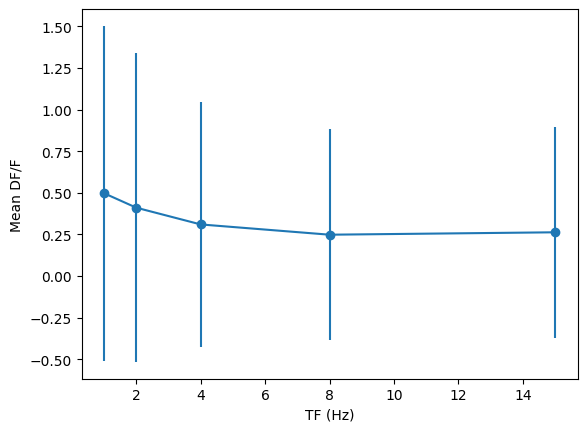

In [51]:
plt.errorbar(tfvals, tuning_tf[:,0], yerr=tuning_tf[:,1], marker='o')
plt.xlabel("TF (Hz)")
plt.ylabel("Mean DF/F")

In [33]:
tuning_tf = np.empty((5,2))
for i, tf in enumerate(tfvals):
    trials = cell_response[:,1]==tf
    tuning_tf[i,0] = cell_response[trials,2].mean()
    tuning_tf[i,1] = cell_response[trials,2].std()

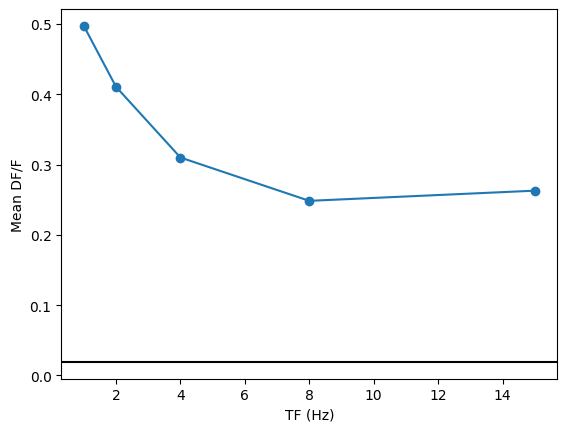

In [53]:
plt.plot(tfvals, tuning_tf[:,0], 'o-')
plt.xlabel("TF (Hz)")
plt.ylabel("Mean DF/F")
plt.axhline(blank_response_mean, color='k')

So far we've looked at one stimulus dimension (e.g. orientation) averaged across all conditions of the other (e.g. temporal frequency) - and vice versa. Now we want to look at these tuning curves for both dimensions.
<p>To begin, let's compute the two-dimensional tuning array for this neuron - computing the mean response for every possible orientation and temporal frequency combination.

What is the shape of the array we will be computing?

In [ ]:
tuning_array = np.empty((8,5))
for i,tf in enumerate(tfvals):
    #select trials of each tf
    tf_trials = cell_response[:,1]==tf
    subset = cell_response[tf_trials]
    for j,ori in enumerate(orivals):
        #select trials of that tf and each ori
        trials = subset[:,0]==ori
        tuning_array[j,i] = subset[trials,2].mean()

Let's start by visualizing this similarly to how we did above: Plot the orientation tuning curve for each temporal frequency value as a separate line:

Text(0, 0.5, 'Mean DF/F')

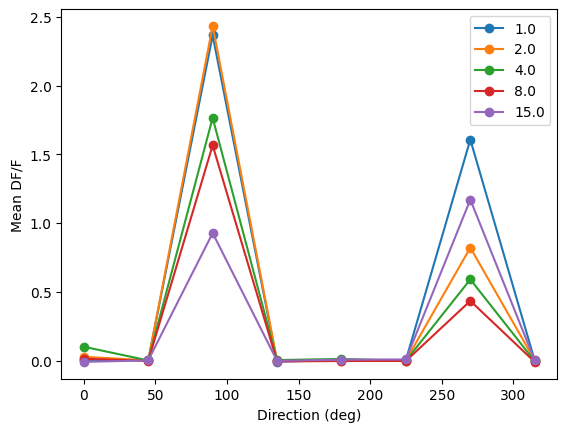

In [ ]:
for i, tf in enumerate(tfvals):
    plt.plot(orivals, tuning_array[:,i], 'o-', label=tf)
plt.legend()
plt.xlabel("Direction (deg)")
plt.ylabel("Mean DF/F")


**Exercise 7:** Plot each temporal frequency tuning curve for each orientation as a separate line.

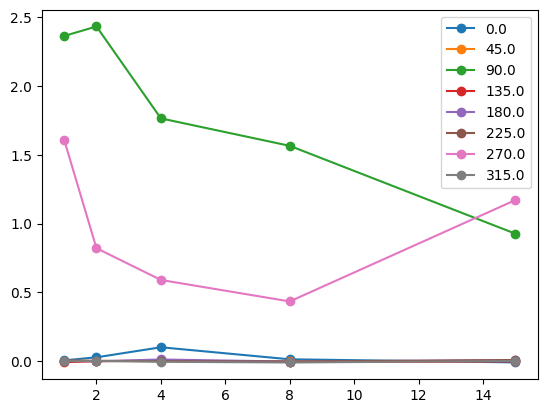

In [ ]:
for i, ori in enumerate(orivals):
    plt.plot(tfvals, tuning_array[i,:], 'o-', label=ori)
plt.legend()
# plt.xlabel("Direction (deg)")
# plt.ylabel("Mean DF/F")

What do we see here?

Another way to visualize two dimensional data is as a heatmap. Let's use <b>plt.imshow</b> to create this heatmap.

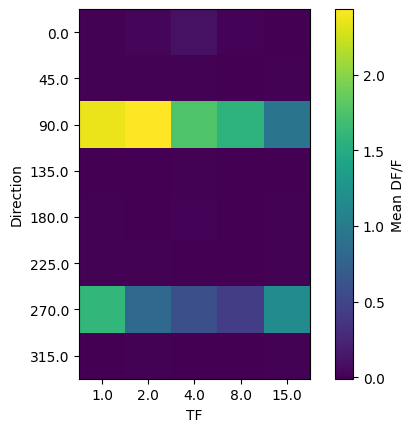

In [ ]:
plt.imshow(tuning_array)
plt.xticks(range(5), tfvals)
plt.yticks(range(8), orivals)
plt.xlabel("TF")
plt.ylabel("Direction")
cbar = plt.colorbar() #Add the colorbar so we know what the colors mean
cbar.set_label("Mean DF/F")

<p>This visualization gives us a great view of how the two dimensions interact, but one disadvantage is that we can't add errorbars or even the blank sweep response to this. But we saw that that information can be important for interpreting what we see in the data.
<p>One approach we can take is to compute the <b>z score</b> where each response is mean subtracted and normalized to the standard deviation. So it shows how far each response deviates from the mean response (rather than the blanksweep response as we plotted above in exercise 5).

In [ ]:
tuning_array_z = (tuning_array - tuning_array.mean())/tuning_array.std()

Text(0.5, 1.0, 'Cell 541513979')

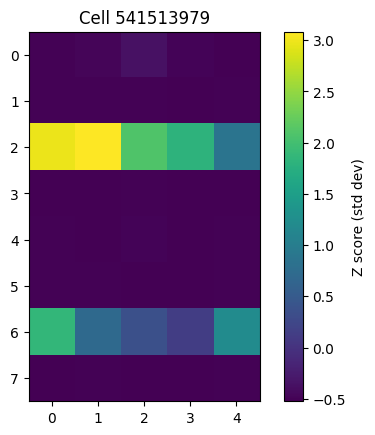

In [ ]:
plt.imshow(tuning_array_z)
cbar = plt.colorbar() #Add the colorbar so we know what the colors mean
cbar.set_label("Z score (std dev)")
plt.title("Cell "+str(cell_id)) #Add a title so we know what the plot is of